# The Art and Science of Data Matching

## Mike Mull (@kwikstep)

<img src="Integrate.png">

<img src="Enrich.png">

<img src='Merge.png'>


If you have two sets of data items, A and B, each with no duplicates then 


$$
\boxed {
\begin{aligned}
M=\{ (a,b)| a \in A, b \in B, a = b \} \\
U=\{ (a,b)| a \in A, b \in B, a \ne b \} \\
\end{aligned}
}
$$


By definition the union of the two sets M and U is the set of all pairs A and B, or:

$$
\boxed {
A \times B = M \cup U
}
$$


## Test Case

- From [On Wages and Hygiene: Surfacing Bad Management in Public Data](http://blog.enigma.io/bad-management-radiates-a-look-at-hygiene-and-wages/)
  - Florida restaurant inspection data
  - Federal wage compliance data (from DOL)

In [77]:
import pandas as pd
# Wage data, drop everything but unique name and addresses, and filter to only Florida.
df_oge = pd.read_csv('./data/ogesdw.whd.whisard.fl.csv')
df_oge_a_fl = df_oge[['trade_nm', 
                      'legal_name', 
                      'street_addr_1_txt', 
                      'cty_nm', 
                      'st_cd', 
                      'zip_cd']].drop_duplicates()

# Florida restaurant inspection data.  Drop everything but unique name and addresses
df_fl = pd.read_csv('./data/fl.restaurant-inspections.csv')
df_fl_a = df_fl[['dba', 
                 'location_address', 
                 'location_city', 
                 'location_zip_code']].drop_duplicates()

## Data Exploration and Profiling

In [78]:
df_oge_a_fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16655 entries, 0 to 16702
Data columns (total 6 columns):
trade_nm             16655 non-null object
legal_name           16565 non-null object
street_addr_1_txt    16655 non-null object
cty_nm               16655 non-null object
st_cd                16655 non-null object
zip_cd               16655 non-null float64
dtypes: float64(1), object(5)
memory usage: 910.8+ KB


In [79]:
df_fl_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53576 entries, 0 to 130642
Data columns (total 4 columns):
dba                  53556 non-null object
location_address     53576 non-null object
location_city        53575 non-null object
location_zip_code    53568 non-null object
dtypes: object(4)
memory usage: 2.0+ MB


### Use `apply()` To Check Field Patterns

In [80]:
t={ord(x): y for (x, y) in zip('0123456789', '9999999999')}

def zip_trans(z): return z.translate(t) if pd.notnull(z) else z

df_fl_a['pzip'] =  df_fl_a.location_zip_code.apply(zip_trans)
print(df_fl_a.groupby('pzip').size())

df_oge_a_fl['pzip'] =  df_oge_a_fl.zip_cd.apply(lambda x: zip_trans(str(int(x))))
print(df_oge_a_fl.groupby('pzip').size())

pzip
99999         47778
99999-9999     1611
999999999      4179
dtype: int64
pzip
99999    16655
dtype: int64


### Use `apply()` With Regex

In [81]:
import re
def leading_patt(s):
    p = (('^[A-Z][a-z]', 'Aa'), ('^[A-Z][A-Z]', 'AA'), ('^[0-9][0-9]', '99'))
    for rx, patt in p:
        if re.search(rx, s):
            return patt
    return 'OTHER'

df_oge_a_fl['patt'] = df_oge_a_fl.trade_nm.apply(leading_patt)
df_oge_a_fl.groupby('patt').size()

patt
99          37
AA        1133
Aa       14690
OTHER      795
dtype: int64

### Look for Duplicates

In [95]:
df_fl_a.groupby(['dba','location_zip_code'])\
       .filter(lambda x: len(x['dba']) > 2)\
       .sort('dba')[['dba',
                     'location_address',
                     'location_city',
                     'location_zip_code']].head(8)

,dba,location_address,location_city,location_zip_code
87993,ATLANTIC VENDORS INC,3111 S ATLANTIC AVE,DAYTONA BEACH SHORES,32118
87994,ATLANTIC VENDORS INC,2225 S ATLANTIC AVE,DAYTONA BCH SHORES,32118
87996,ATLANTIC VENDORS INC,2411 S ATLANTIC AVE,DAYTONA BCH SHORES,32118
87997,ATLANTIC VENDORS INC,3125 S ATLANTIC AVE,DAYTONA BCH SHORES,32118
87999,ATLANTIC VENDORS INC,400 N ATLANTIC AVE,DAYTONA BCH,32118
88045,ATLANTIC VENDORS INC,2209 S ATLANTIC AVE,DAYTONA BCH SHORES,32118
88061,ATLANTIC VENDORS INC,2125 S ATLANTIC AVE,DAYTONA BCH,32118
88291,ATLANTIC VENDORS INC,2209 S ATLANTIC AVE,DAYTONA BEACH SHORES,32118


### Make a Histogram of String Length

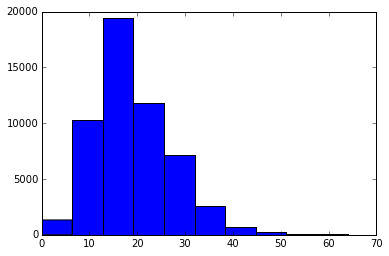

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

_ = plt.hist(df_fl_a.dba.apply(lambda x: len(x) if pd.notnull(x) else 0))

## Comparing Fields

In practice we compare against attributes of rA or rB

$$
Sim(r_{A}, r_{B}) = Sim(a_{1}, a_{2}..., a_{n}; b_{1}, b_{2}, ..., b_{n}) \\
= [s_{1}(a_{1}, b_{1}), ..., s_{n}(a_{n}, b_{n})]
$$

where the _si_ are comparison functions for each field.  So we end up with a comparison vector for each record.

### Preprocessing and Transformation

- Simple text transformations: lowerize, remove punctuation
- More complex:
  - Replace patterns ('&' -> 'and')
  - Standardize abbreviations, roman numerals, ordinals
  - In some situations, remove stop words, use stemming
- Standard length or format (eg, with zip codes)
- Parsing or tokenization
- Imputation


In [84]:
# Process name and zip code fields
name_prep = lambda x:x.lower().translate({None:"'.,"}) if pd.notnull(x) else ''
df_fl_a['nname'] = df_fl_a.dba.apply(name_prep)
df_oge_a_fl['nname'] = df_oge_a_fl.trade_nm.apply(name_prep)

df_fl_a['nzip'] = df_fl_a.location_zip_code.apply(lambda x:x[0:5] if pd.notnull(x) else x)
df_oge_a_fl['nzip'] = df_oge_a_fl.zip_cd.apply(lambda x: str(int(x)))

# Split out street number into separate field
df_fl_a['snum'] = df_fl_a.location_address.str.split(' ',1).apply(lambda x:x[0])
df_oge_a_fl['snum'] = df_oge_a_fl.street_addr_1_txt.str.split(' ',1).apply(lambda x:x[0])

### Approximate String Comparison

- NLTK
  - Edit distance
  - Jaccard distance
- Difflib
  - SequenceMatcher
- Jellyfish
  - __Levenshtein__ 
  - Jaro and __Jaro-Winkler__
  - Soundex
- FuzzyWuzzy

- Token-Based
  - __Jaccard similarity__
  - __SoftTf-Idf__


### Levenshtein/Edit Distance

In [85]:
from jellyfish import levenshtein_distance
print(levenshtein_distance('pydata', 'padata'))    # 1-character change
print(levenshtein_distance('pydata', 'pandata'))   # Insert character
print(levenshtein_distance('pydata', 'pandasa'))   # 1-character change
print(levenshtein_distance('pydata', 'pandas'))    # Character deletion

1
2
3
4


### Jaro/Jaro-Winkler

$$
Jaro(s_{1}, s_{2}) = w_{1}\frac{c}{L_{1}} + w_{2}\frac{c}{L_{2}} + w_{t}\frac{c-\tau}{c}
$$
where:
$$
L_{1} \mbox{ is length of }s_{1} \\
L_{2} \mbox{ is length of }s_{2} \\
c \mbox{ is number of characters in common } \\
\tau \mbox{ is number of transpositions } \\
$$

$$
JaroWinkler(s_{1}, s_{2}) = Jaro(s_{1}, s_{2}) + 0.1 i(1 - Jaro(s_{1}, s_{2}))
$$
where:
__i__ is min(4, number of initial characters that match)

### Jaccard

In [86]:
def jaccard(s1, s2):
    ''' Jaccard similarity score.  (1 - jaccard) is a valid distance metric '''
    a = set(s1)
    b = set(s2)
    if len(a) == 0 and len(b) == 0:
        return 0
    return len(a & b) / len(a | b)

print(jaccard('pydata', 'pandas'))
print(jaccard(['bag', 'of', 'words'], ['words', 'bag']))

0.42857142857142855
0.6666666666666666


In [87]:
# N-gram function courtesy of Peter Norvig
def ngrams(seq, n):
    "List all the (overlapping) ngrams in a sequence."
    return [seq[i:i+n] for i in range(1+len(seq)-n)]

print(jaccard(ngrams('pydata', 2), ngrams('pandas', 2)))
print(jaccard(ngrams('pydata', 3), ngrams('pandas', 3)))

0.1111111111111111
0.0


### SoftTf-Idf

- _SoftTf-Idf_ is a variation of Tf-Idf (_Term Frequency-Inverse Document Frequency_) that includes similar tokens

$$
tfidf(t,d,D) = tf(t,d) * idf(t, D)
$$

$$
idf(t,D) = log \frac{|D|}{| d \in D, t \in d |}
$$

-  In the SoftTd-Idf scheme _similar_ tokens are included.

$$
\{ sim(w,v) > \theta | w \in X, v \in Y \} 
$$


## Human Names

|  Name |  Source  |
| --- |  --- |
| RICHARD ALLAN BREGGER | Finra |
| RICHARD A BREGGER | DOL |
| BREGGER RICHARD A | DOL |
| RICHAPT) A BREGGER | DOL (OCR error) |
| RICHARD A BREGGER AXA FINANCIAL | DOL |
| RICHARD D BREGGER | DOL |
| RICHARDBREGGER | Record Keeper |

<img src='bregger.png'>

### Stupid Human (Name) Tricks

- Almost always want to parse names into (first, middle or MI, last)
- Do not use regex
- Substituting first names is helpful, but build your own database of alternatives
- Do not use regex
- As you match, retain alternatives and do look-ups

### The _nameparser_ library

In [88]:
from nameparser import HumanName

HumanName('DR. RICHARD ALLAN "Rick" BREGGER, Ph.D')

<HumanName : [
	title: 'DR.' 
	first: 'RICHARD' 
	middle: 'ALLAN' 
	last: 'BREGGER' 
	suffix: 'Ph.D'
	nickname: 'Rick'
]>

In [89]:
HumanName('BREGGER, RICHARD A')

<HumanName : [
	title: '' 
	first: 'RICHARD' 
	middle: 'A' 
	last: 'BREGGER' 
	suffix: ''
	nickname: ''
]>

In [90]:
HumanName('BREGGER RICHARD A')

<HumanName : [
	title: '' 
	first: 'BREGGER' 
	middle: 'RICHARD' 
	last: 'A' 
	suffix: ''
	nickname: ''
]>

## Addresses and Geocoding

- Addresses are more frequently separated into multiple fields, usually street address, city, state, zip code in the source data.
- Zip codes have 3,5, and 9 (Zip+4) variants
- Since Zip codes are designed for efficiency of mail delivery, they aren't a consistent indicator of physical proximity.
  - Zips are not even areas
- The street number can be a useful identifier
- Different businesses might have identical addresses (aka, "the food-court effect")

In [94]:
df_fl_a[df_fl_a.location_address=='39 S BENEVA RD'][['dba',
                     'location_address',
                     'location_city',
                     'location_zip_code']]

,dba,location_address,location_city,location_zip_code
129483,HOSTED GOURMET,39 S BENEVA RD,SARASOTA,34232
129503,STAMPER CHEESE COMPANY,39 S BENEVA RD,SARASOTA,34232
129507,MOUTHOLE BBQ,39 S BENEVA RD,SARASOTA,34232
129515,PALEO CONNECTION LLC,39 S BENEVA RD,SARASOTA,34232
129516,DOLCE VITA LLC,39 S BENEVA RD,SARASOTA,34232
129517,BRICKS BBQ,39 S BENEVA RD,SARASOTA,34232
129521,WINGS ON WHEELS LLC,39 S BENEVA RD,SARASOTA,34232
130612,MOBILE BISTRO,39 S BENEVA RD,SARASOTA,34240
130625,RI QUISIMO,39 S BENEVA RD,SARASOTA,34232


### Geocoders

- Google
- OpenStreetMap Nominatim
- geocoder.us
- TIGER
  - Addon for PostGIS
  - Uses US Census Bureau TIGER Geodatabases

```
SELECT g.rating, ST_X(g.geomout) As lon, ST_Y(g.geomout) As lat, 
(addy).address As stno, (addy).streetname As street, 
(addy).streettypeabbrev As styp, (addy).location As city, (addy).stateabbrev As st,(addy).zip 
FROM geocode('555 Lake Border Drive, Apopka, FL 32703') As g; 

 rating |        lon        |       lat        | stno |   street    | styp |  city  | st |  zip  
--------+-------------------+------------------+------+-------------+------+--------+----+-------
      0 | -81.4651538792139 | 28.6714046741846 |  555 | Lake Border | Dr   | Apopka | FL | 32703
```
```
datanav=# SELECT g.rating, ST_X(g.geomout) As lon, ST_Y(g.geomout) As lat, 
(addy).address As stno, (addy).streetname As street, 
(addy).streettypeabbrev As styp, (addy).location As city, (addy).stateabbrev As st,(addy).zip 
FROM geocode('5555 Lake Border Drive, Apopka, FL 32703') As g;  
 rating |        lon        |       lat        | stno |   street    | styp |  city  | st |  zip  
--------+-------------------+------------------+------+-------------+------+--------+----+-------
     10 | -81.4651087639419 | 28.6712609342955 |  699 | Lake Border | Dr   | Apopka | FL | 32703
```

```
datanav=# SELECT g.rating, ST_X(g.geomout) As lon, ST_Y(g.geomout) As lat, 
(addy).address As stno, (addy).streetname As street, 
(addy).streettypeabbrev As styp, (addy).location As city, (addy).stateabbrev As st,(addy).zip 
FROM geocode('Apopka, FL 32703') As g;  
 rating |       lon        |       lat        | stno | street | styp |  city  | st |  zip  
--------+------------------+------------------+------+--------+------+--------+----+-------
    100 | -81.552957384847 | 28.6706870842484 |      |        |      | Apopka | FL | 32703
```


#### Comparing Locations

- To compute actual _distance_ you need to use Vincenty or Great Circle distance
- However for comparison, L1 norm will probably work.

In [92]:
from geopy.distance import vincenty

l0 = (-81.4651538792139,  28.6714046741846)
l10 = (-81.4651087639419, 28.6712609342955)
l100 = (-81.552957384847,  28.6706870842484)

vincenty(l0, l10).miles, vincenty(l0, l100).miles

(0.0034628723732747875, 6.092525294476887)

## Blocking

For our example case, we have over 800 million record pairs in A x B.  __Blocking__ is the process of reducing the number of candidate pairs by assiging the records in each data set to a block.  Only record pairs that have the same block key will be compared.

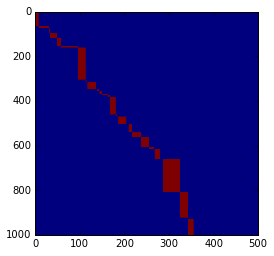

In [93]:
df_fl_a['k'] = 1
df_oge_a_fl['k'] = 1
df_block = df_fl_a.sort('nzip').iloc[0:1000].merge(df_oge_a_fl.sort('nzip').iloc[0:500], 
                                                  on='k')[['nzip_x', 'nzip_y']]

z = (df_block.nzip_x == df_block.nzip_y).values
z.shape = (1000, 500)
_=plt.imshow(z, aspect=0.5)

### Using Multiple Properties

- Blocking with an existing property will often defeat the purpose of matching
- Using multiple properties (eg, Zip, Street Num) increases the probability of including candidates
  - At the expense of multiple blocks per record.
- This is equivalent to Locality Sensitive Hashing (LSH)

### N-Gram Based Blocks

In [48]:
def window(fseq, window_size=5):
...     for i in range(len(fseq) - window_size + 1):
...         yield fseq[i:i+window_size]

n1 = ngrams('mainstreet cafe', 2)
[''.join(x) for x in window(n1)]
n2 = ngrams('the main street cafe inc', 2)
set([''.join(x) for x in window(n1)]) & set([''.join(x) for x in window(n2)])

{'eeett  cca',
 'ett  ccaaf',
 'reeeett  c',
 'sttrreeeet',
 't  ccaaffe',
 'trreeeett '}

### Canopy Clustering

- Generate blocking keys for record (for example, bigrams of name)
- Add record to block if blocks keys are sufficiently similar (eg, Jaccard similarity of bigram sets)

## Classifying Matches

### Simple Scoring

Recall that for each record pair we're supposing that we have a vector where each element of the vector is a comparison of the comparable attributes:
$$
[s_{1}(a_{1}, b_{1}), ..., s_{n}(a_{n}, b_{n})]
$$

- Sum the individual scores and set a threshold T1.  Anything > T1 is a match
- For bonus points, choose a second threshold T2 so that anything < T2 is a non-match
- Any sum between T1 and T2 needs review.


### Rules

$$
(JaroWinkler(Name_{A}, Name_{B}) > 0.9) \land (Zip_{A} = Zip_{B}) \implies M
$$

$$
(JaroWinkler(Name_{A}, Name_{B}) < 0.7) \lor (Zip_{A} \neq Zip_{B}) \implies U
$$


### Probabilistic Matching (Fellugi-Sunter)

Suppose our comparison vector is:

$$
  \gamma(r_{A}, r_{B}) = [JaroWinkler(Name_{A}, Name_{B}) > 0.9, (Zip_{A} = Zip_{B}), Levenshtein(StreetNum_{A}, StreetNum_{B}) < 2]
$$

We'll call this type of comparison vector an _agreement pattern_.  The are 8 separate patterns (2^3) in this case


In [49]:
import itertools
pd.DataFrame(data=list(itertools.product(['match','unmatch'], repeat=3)),
             columns=['name', 'zip', 'street num'])

,name,zip,street num
0,match,match,match
1,match,match,unmatch
2,match,unmatch,match
3,match,unmatch,unmatch
4,unmatch,match,match
5,unmatch,match,unmatch
6,unmatch,unmatch,match
7,unmatch,unmatch,unmatch


The method then defines the following two conditonal probabilities:

$$
\begin{align}
m(\gamma) = P[\gamma(r_{A}, r_{B})| (r_{A}, r_{B}) \in M] \\
= \sum_{a,b \in M} P[\gamma(r_{A},r_{B})]P[(r_{A}, r_{B}) \in M]
\end{align}
$$
and
$$
\begin{align}
u(\gamma) = P[\gamma(r_{A}, r_{B})| (r_{A}, r_{B}) \in U] \\
= \sum_{a,b \in U} P[\gamma(r_{A},r_{B}]P[(r_{A}, r_{B}) \in U]
\end{align}
$$


The Fellegi-Sunter method results in a _linkage rule_:

$$
	\begin{array}{ll}
		\frac{m}{u} > T_{\mu}  & \mbox{match}  \\
        T_{\mu} < \frac{m}{u} < T_{\lambda}  & \mbox{potential match}  \\
		\frac{m}{u} < T_{\lambda}  & \mbox{non-match}  \\
	\end{array}
$$


#### Simplifications


- Conditional Independence
$$
Pr(\texttt{name matches}, \texttt{zip matches}, \texttt{street matches}|M) = Pr(\texttt{name matches}|M) Pr(\texttt{zip matches}|M) Pr(\texttt{street matches}|M)
$$


$$
m(\texttt{name matches}) = \frac{Pr(\texttt{name matches}|M)}{Pr(\texttt{name matches}|U)}
$$


- Convert m/u ratios to weights:

$$
w_{i} = 
\left\{
	\begin{array}{ll}
		log_{2}(\frac{m_{i}}{u_{i}})  & \mbox{if agreement on field i}  \\
		log_{2}(\frac{1-m_{i}}{1-u_{i}}) & \mbox{if otherwise}
	\end{array}
\right.
$$

But Wait!

- By definition we don't know which records are in M and which are in U
- In some cases __m/u__ can be estimated, and then progressively refined.
- Most general method is Expectation-Maximization algorithm

- Assume distribution of patterns is a mixture of distributions, with parameters:

$$
\Phi = ((m_{1}\dots m_{k}), (u_{1}\dots u_{k}), p)
$$

- Also assume there is a _latent variable_ __g__ that determines whether a record pair is in __M__ or __U__.  Then the likelihood function for the data we have is:


$$
f(g,\gamma; \Phi) = \prod_{j=1}({pP(\gamma_{j}|r_{j} \in M))^g((1-p)P(\gamma_{j}|r_{j} \in U)})^{(1-g)}
$$


In [50]:
import operator
import numpy as np
from functools import reduce

mh = np.array([ 0.08910887,  0.98090761,  0.88638131])
uh = np.array([ 0.00019569,  0.00198455,  0.0003152 ])

def mp(gamma, mh, uh):
    return reduce(operator.mul, (mh[i] ** g * (1 - mh[i]) ** (1 - g) for i,g in enumerate(gamma)))

def up(gamma, mh, uh):
    return reduce(operator.mul, (uh[i] ** g * (1 - uh[i]) ** (1 - g) for i,g in enumerate(gamma)))

def log_score(gamma, mh, uh):
    return sum([np.log2(mh[i]/uh[i]) if g==1 else np.log2((1-mh[i])/(1-uh[i])) for i,g in enumerate(gamma)])

df_scores = pd.DataFrame(data=list(itertools.product([1,0], repeat=3)),
             columns=['name', 'zip', 'street num'])
df_scores['m'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: mp(p,mh,uh), axis=1)
df_scores['u'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: up(p,mh,uh), axis=1)
df_scores['mu'] = df_scores.m/df_scores.u
df_scores['w'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: log_score(p,mh,uh), axis=1)
df_scores.sort('mu', ascending=False, inplace=True)
df_scores['cu'] = df_scores.u.cumsum()
df_scores['cm'] = df_scores.m.cumsum()
df_scores

,name,zip,street num,m,u,mu,w,cu,cm
0,1,1,1,0.077476,1.224100e-10,6.329257e+08,29.237461,1.224100e-10,0.077476
4,0,1,1,0.791982,6.254078e-07,1.266345e+06,20.272239,6.255302e-07,0.869458
1,1,1,0,0.009931,3.882342e-07,2.558027e+04,14.642744,1.013764e-06,0.879389
2,1,0,1,0.001508,6.155908e-08,2.449682e+04,14.580307,1.075323e-06,0.880897
5,0,1,0,0.101518,1.983536e-03,5.118046e+01,5.677521,1.984612e-03,0.982416
6,0,0,1,0.015415,3.145129e-04,4.901273e+01,5.615085,2.299124e-03,0.997831
3,1,0,0,0.000193,1.952401e-04,9.900612e-01,-0.014410,2.494365e-03,0.998024
7,0,0,0,0.001976,9.975056e-01,1.980894e-03,-8.979633,1.000000e+00,1.000000


### Supervised Learning

- Requires training data where matches/non-matches are already known
- Always imbalanced since there are many more non-matches than matches
- Harder to apply in production situations

In [22]:
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

df_matches = pd.read_csv('./data/matches.csv')

df_matches['snum_dist'] = df_matches[['snum_x', 'snum_y']].apply(lambda s: levenshtein_distance(str(s[0]), str(s[1])),
                                                                 axis=1)
df_matches['city_sim'] = df_matches[['cty_nm', 'location_city']].apply(lambda c: jaccard( ngrams(c[0].lower(),2),
                                                                                          ngrams(c[1].lower(),2)),
                                                                      axis=1)
df_matched = df_matches[df_matches.match==1]
df_unmatched = df_matches[df_matches.match==0]
df_bal = pd.concat( [df_matched, 
                     df_unmatched.sample(len(df_matched)) ] ).reset_index()

y = df_bal.match
X = df_bal[['jw', 'snum_dist', 'city_sim']].as_matrix()

kf = KFold(len(y),n_folds=5,shuffle=True)
y_pred = y.copy()

clf = RandomForestClassifier()

# Iterate through folds
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train = y[train_index]
    # Initialize a classifier with key word arguments

    clf.fit(X_train,y_train)
    y_pred[test_index] = clf.predict(X_test)

print(np.mean(y == y_pred))

0.997348484848


## Active Learning and _Dedupe_

_PAUSE FOR DEMO_

## Information Quality Metrics for Matching

- Number of References
- Class statistics: size, max
- Talburt-Wang Index
- Rand Index
